In [3]:
%matplotlib inline
import sys,os
import  numpy as np
import matplotlib.pyplot as plt
import torch
import spartan2.spartan as st
from spartan2.drawutil import draw_ts_heatmap

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] ="0"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
st.config(st.engine.SINGLEMACHINE)

In [5]:
# load time data
data = st.loadTensor(name = "example_time", path = "inputData/", col_types = [float, float, float], hasvalue=True)

Info: Tensor is loaded
           ----------------------
             attr     |	2
             values   |	True
             nonzeros |	36000



In [6]:
time_series = data.toTimeseries(attrlabels=['ecg_low', 'ecg_high'])

In [17]:
time_series.attrlists.shape
seg=st.series_segmentation.create(time_series,st.sseg_policy.RPeaks,"slide")

ts_segs=seg.run(360,120,136,None)
ts_segs=ts_segs[:,:1,:]
print(ts_segs.shape)

(122, 1, 256)


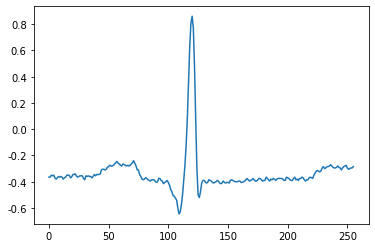

In [18]:
plt.plot(ts_segs[2][0,:])

In [19]:
# create a beatgan model

ad_model = st.anomaly_detection.create(time_series, st.ad_policy.BEATGAN, "my_beatgan_model")

In [20]:
### param for train model
param = {
    'network':'CNN',
    'net_type':'gru',
    'layers':1,
    'seq_len': 256,
    'input_size':1,
    'hidden_size':100,
    'rep_size':20,
    'batch_size':64,
    'max_epoch':5,
    'lr': 0.01,
    'lambda':1
}

In [21]:
ad_model.init_model(param,device)

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

In [ ]:
ad_model.train(ts_segs)

In [ ]:
ad_model.test(ts_segs)

In [ ]:
ad_model.export("")

In [22]:
## param for run
param_run = {
    'model_path':"../spartan2/models/beatgan/model/ecg_cnn.pth",
    'network':'CNN',
    'net_type':'gru',
    'layers':1,
    'seq_len': 256,
    'input_size':1,
    'hidden_size':100,
    'rep_size':20,
    'batch_size':64,
    'max_epoch':5,
    'lr': 0.01,
    'lambda':1
}
### run model (load form model_path)
beatgan,res=ad_model.run(None,ts_segs,param_run,device)

'''
res is a list, format: 
[mean anomalous socre, original time series, reconstructed time series, reconstruction error for each tick]
'''

### run model from cache
#ad_model.run(beatgan,ts_segs,param_run,device)

[Conv1d(1, 32, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(32, 64, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(128, 256, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(256, 512, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), LeakyReLU(negative_slope=0.2, inplace=True), Conv1d(512, 1024, kernel_size=(4,), stride=(2,), padding=(1,), bias=False), Ba

In [23]:
## sort by reconstruction error, get the sorted indices
ind=np.argsort(res[0])


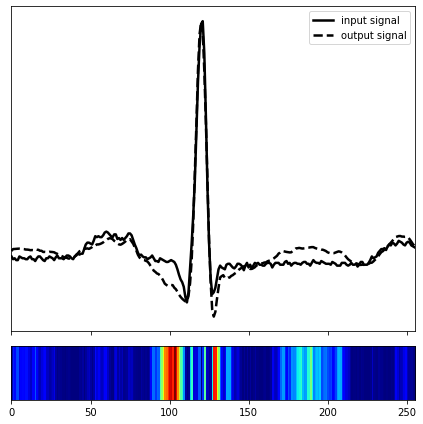

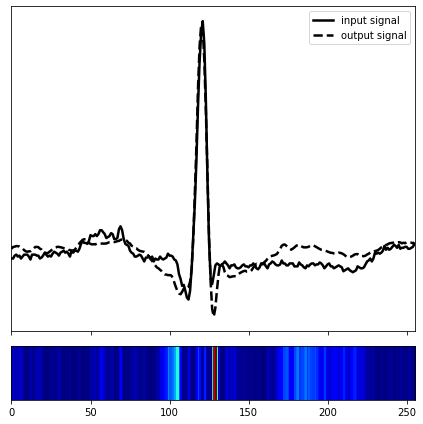

In [24]:
## show reconstruction examples of low anomalousness score
draw_ts_heatmap(res[1][ind[0]],res[2][ind[0]],max_heat=max(res[0]),min_heat=min(res[0]))
draw_ts_heatmap(res[1][ind[1]],res[2][ind[1]],max_heat=max(res[0]),min_heat=min(res[0]))

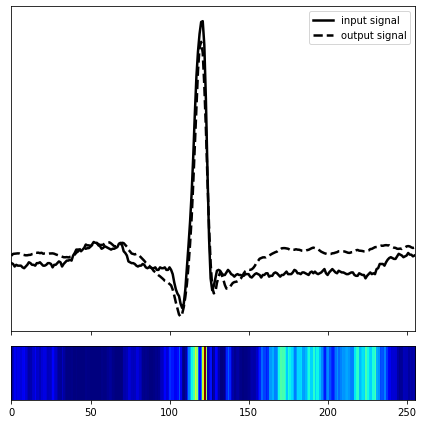

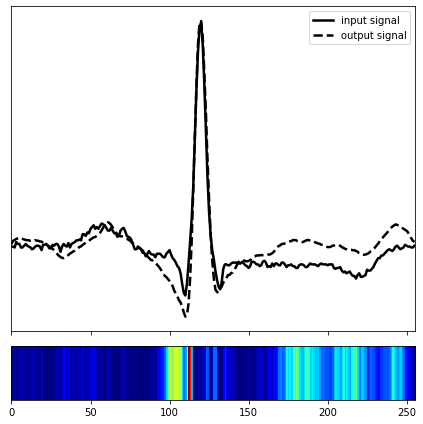

In [25]:
## show reconstruction examples of high anomalousness score
draw_ts_heatmap(res[1][ind[-1]],res[2][ind[-1]],max_heat=max(res[0]),min_heat=min(res[0]))
draw_ts_heatmap(res[1][ind[-2]],res[2][ind[-2]],max_heat=max(res[0]),min_heat=min(res[0]))